In [1]:
from scipy.sparse import csr_matrix
import implicit
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import metrics
# from metrics import hitrate_k

In [4]:
root = '../data/parquets/'
book = pd.read_parquet(root + '/book_views.csv.parquet.gz', engine='pyarrow')

In [8]:
book

,user_id,item_id,rate,timestamp
0,4,234705,0.0,1.363316e+09
1,116482,234705,0.0,1.363334e+09
2,112934,234170,10.0,1.363334e+09
3,112934,95396,10.0,1.363336e+09
4,35936,205566,0.0,1.363347e+09
...,...,...,...,...
1097012,2045727,230231,NaN,1.632047e+09
1097013,2045727,94061,NaN,1.632047e+09
1097014,2045727,245080,NaN,1.632048e+09
1097015,854238,228254,NaN,1.632050e+09


In [9]:
users = book.drop_duplicates(subset = 'user_id').user_id.to_list()
users

[4,
 116482,
 112934,
 35936,
 148759,
 13640,
 93147,
 49042,
 151556,
 169327,
 62079,
 102324,
 45964,
 132810,
 82500,
 215446,
 110144,
 153001,
 196654,
 72880,
 116675,
 22365,
 211239,
 191759,
 85269,
 204759,
 29001,
 56909,
 188267,
 45917,
 92423,
 4601,
 177556,
 178963,
 127118,
 3077,
 25622,
 154751,
 133760,
 140067,
 17566,
 145762,
 151656,
 126674,
 120157,
 192229,
 41442,
 83018,
 58895,
 89568,
 193472,
 191991,
 64428,
 120038,
 176904,
 41637,
 7035,
 94415,
 27078,
 175258,
 195201,
 93599,
 99322,
 50896,
 65925,
 214326,
 94427,
 87291,
 118657,
 121412,
 86808,
 81710,
 185105,
 36055,
 146163,
 17221,
 128304,
 215000,
 165080,
 199063,
 152077,
 156257,
 17699,
 120469,
 12887,
 62385,
 186544,
 89451,
 61043,
 86127,
 30877,
 68977,
 187017,
 47342,
 130775,
 201214,
 195951,
 79053,
 37699,
 199505,
 199791,
 3538,
 36428,
 117034,
 125994,
 35748,
 113103,
 123873,
 69106,
 65558,
 201280,
 180002,
 218179,
 106083,
 205239,
 125455,
 200055,
 30487,
 

In [13]:
reversed_views = book.iloc[::-1]

In [14]:
def get_test_subset(reversed_views):
    test_df = pd.DataFrame()
    for user in tqdm(users):
        user_data = reversed_views[reversed_views.user_id == user]
        if user_data.count()[0]>3:
            for i in range(3):
                test_df = test_df.append(user_data.iloc[i])
        else:
            test_df = test_df.append(user_data)
    return test_df

In [16]:
book_test = get_test_subset(reversed_views)

  0%|          | 0/84525 [00:00<?, ?it/s]

In [18]:
book_train = pd.concat([views, book_test]).drop_duplicates(keep=False)

In [19]:
book_test.head()

,item_id,rate,timestamp,user_id
1067669,246366.0,NaN,1.621501e+09,4.0
1065193,48928.0,NaN,1.620711e+09,4.0
1029569,110157.0,NaN,1.609244e+09,4.0
5434,92949.0,0.0,1.368568e+09,116482.0
1,234705.0,0.0,1.363334e+09,116482.0


In [20]:
book_train.head()

,user_id,item_id,rate,timestamp
0,4.0,234705.0,0.0,1.363316e+09
2,112934.0,234170.0,10.0,1.363334e+09
3,112934.0,95396.0,10.0,1.363336e+09
4,35936.0,205566.0,0.0,1.363347e+09
5,35936.0,227052.0,0.0,1.363348e+09


# Look through data

## Book

In [21]:
print('median:', views.groupby('user_id').count().reset_index().rate.median()) 
print('mean:', views.groupby('user_id').count().reset_index().rate.mean().round()) # среднее кол-во оценок выставленных пользователем
print('max:', views.groupby('user_id').count().reset_index().rate.max())

median: 2.0
mean: 12.0
max: 26651


<AxesSubplot:>

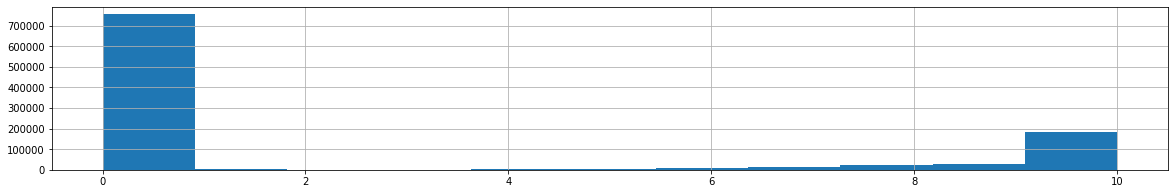

In [22]:
views.rate.hist(bins=11, figsize=(20, 3)) 

<AxesSubplot:>

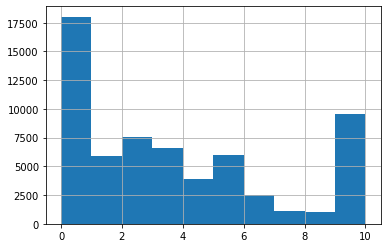

In [23]:
views.groupby('item_id').mean().rate.hist() # распределение по оценкам для айтемов

In [24]:
print('median:', views.groupby('item_id').count().reset_index().rate.median()) #кол-во оценок
print('mean:', views.groupby('item_id').count().reset_index().rate.mean().round())
print('max:', views.groupby('item_id').count().reset_index().rate.max())

median: 3.0
mean: 16.0
max: 6804


<AxesSubplot:>

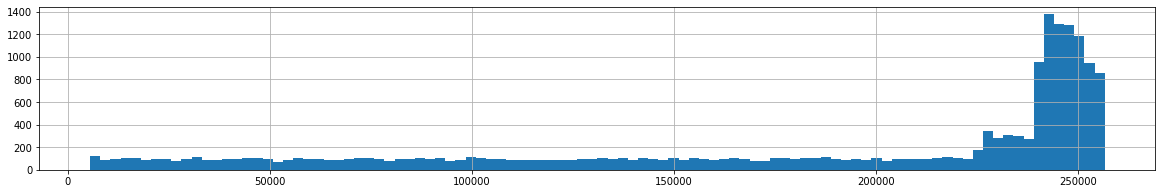

In [27]:
book_test.item_id.drop_duplicates().hist(bins=100, figsize=(20, 3))

<AxesSubplot:>

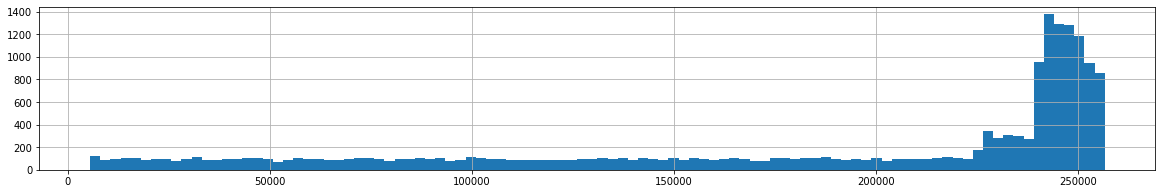

In [28]:
book_test.item_id.drop_duplicates().hist(bins=100, figsize=(20, 3))

In [15]:
# delete negative samples
train_df.shape

(873451, 3)

## Manga

In [6]:
manga = pd.read_parquet(root + '/manga_1_views.csv.parquet.gz', engine='pyarrow')

In [8]:
manga.head()

,user_id,item_id,rate,timestamp
0,17934,2718,NaN,1.339927e+09
1,18313,2718,10.0,1.339927e+09
2,43620,2718,5.0,1.339927e+09
3,63405,2718,10.0,1.339927e+09
4,65907,2718,NaN,1.339927e+09


In [14]:
print('median:', manga.groupby('user_id').count().reset_index().rate.median()) 
print('mean:', manga.groupby('user_id').count().reset_index().rate.mean().round()) # среднее кол-во оценок выставленных пользователем
print('max:', manga.groupby('user_id').count().reset_index().rate.max())

median: 10.0
mean: 66.0
max: 13002


<AxesSubplot:>

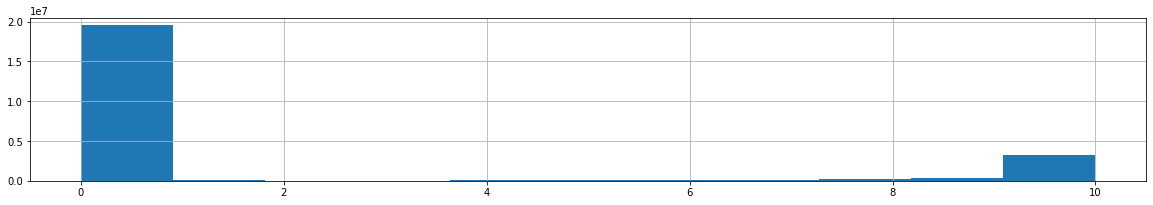

In [9]:
manga.rate.hist(bins=11, figsize=(20, 3)) 

<AxesSubplot:>

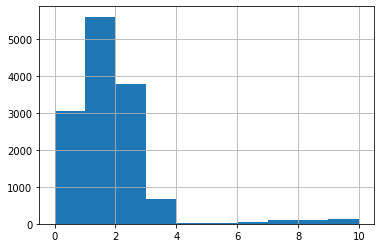

In [10]:
manga.groupby('item_id').mean().rate.hist()

In [12]:
print('median:', manga.groupby('item_id').count().reset_index().rate.median()) #кол-во оценок
print('mean:', manga.groupby('item_id').count().reset_index().rate.mean().round())
print('max:', manga.groupby('item_id').count().reset_index().rate.max())

median: 627.0
mean: 1749.0
max: 64174


# Preparation

In [16]:
d = train_df.groupby('user_id').sum()['rate']
dislikers = d[d <= 0].index.to_list()

In [17]:
test_items = test_df.item_id.drop_duplicates()

train_df = train_df[train_df.item_id.isin(test_items) & (~train_df.user_id.isin(dislikers))]
test_df = test_df[(test_df.user_id.isin(train_df.user_id.drop_duplicates()))]
train_df.shape

(502822, 3)

In [18]:
calc_preference = lambda v: 1 if v>0 else -10
train_df['metric']= train_df.rate.apply(calc_preference)

alpha = 10
train_df.metric = train_df.metric * alpha * train_df.rate

train_df.rate = train_df.metric
train_df = train_df.drop('metric', axis=1)

In [19]:
df_users = pd.read_csv(path + 'users.csv')
df_users.head(2)

NameError: name 'path' is not defined

In [23]:
df_manga = pd.read_parquet(path + '/manga/views.parquet.gz', engine='pyarrow')
df_manga.head(2)

,item_id,rate,user_id
0,2718,10.0,18313
1,2718,5.0,43620


# Filter data

<AxesSubplot:>

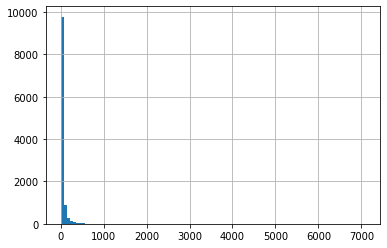

In [24]:
train_df.groupby('user_id').count()['rate'].hist(bins=100)

# indexing data sequentially

In [25]:
users = sorted(train_df.user_id.drop_duplicates().to_list())
items = sorted(train_df.item_id.drop_duplicates().to_list())
print(len(users), len(items))

11396 16336


In [26]:
users_pivot = pd.DataFrame.from_records([(uid, i) for i, uid in enumerate(users)], columns='user_id user_index'.split())
items_pivot = pd.DataFrame.from_records([(iid, i) for i, iid in enumerate(items)], columns='item_id item_index'.split())
users_pivot.head()

,user_id,user_index
0,4.0,0
1,76.0,1
2,234.0,2
3,347.0,3
4,485.0,4


In [27]:
train_df = pd.merge(train_df, users_pivot, on='user_id')
train_df = pd.merge(train_df, items_pivot, on='item_id') 
train_df.head()

,item_id,rate,user_id,user_index,item_index
0,234705.0,-0.0,4.0,0,8618
1,234705.0,100.0,4.0,0,8618
2,234705.0,100.0,151556.0,1711,8618
3,234705.0,100.0,102324.0,1103,8618
4,234705.0,-0.0,72880.0,795,8618


In [28]:
indexed_df = train_df.drop('user_id item_id'.split(), axis=1)
indexed_df.head()

,rate,user_index,item_index
0,-0.0,0,8618
1,100.0,0,8618
2,100.0,1711,8618
3,100.0,1103,8618
4,-0.0,795,8618


In [29]:
users = indexed_df.user_index.to_list()
items = indexed_df.item_index.to_list()
rate  = indexed_df.rate.to_list()

shape = (len(set(users)), len(set(items)))
ui_mat = csr_matrix((rate, (users, items)), shape=shape)

In [30]:
ui_mat.shape

(11396, 16336)

In [31]:
# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=10, calculate_training_loss=True, iterations=20)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(ui_mat)

  0%|          | 0/20 [00:00<?, ?it/s]

# Calc metrics

In [32]:
ui_mat.shape

(11396, 16336)

In [33]:
recs = []

k = 100
for uid, uix in tqdm(list(users_pivot.to_records(index=False))):
    recs.append(model.recommend(uix, ui_mat, N=k, filter_already_liked_items=False))

  0%|          | 0/11396 [00:00<?, ?it/s]

In [34]:
gt = test_df.groupby('user_id')['item_id'].apply(list).tolist()

items_pivot_dict = {rec_id : item_id for item_id, rec_id in list(items_pivot.to_records(index=False))}
# select only items ids and map it to real ids. Without mapping cant calculating metrics with gt dataframe 
rec_items = list(map(lambda rec_list: [items_pivot_dict[x[0]] for x in rec_list], recs))

In [35]:
mean_average_presision_k(rec_items, gt, k=k)

NameError: name 'mean_average_presision_k' is not defined

In [38]:
hitrate_k(rec_items, gt, k=k)

NameError: name 'hitrate_k' is not defined